In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

<h1>Первичный анализ данных</h1>

Считаем данные по росту и весу (из файла *weights_heights.csv*) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

Построим гистограммы распределения признаков:

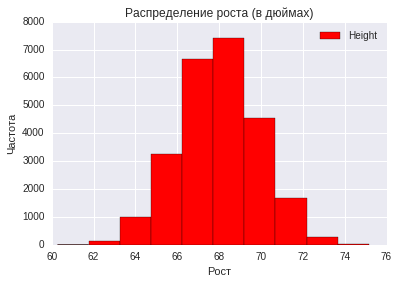

In [3]:
# гистограмма распределения роста
data.plot(y='Height', kind='hist', color='red',  title='Распределение роста (в дюймах)').set(
    xlabel='Рост', ylabel='Частота')

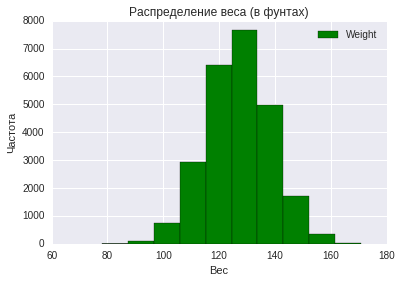

In [4]:
# гистограмма распределения веса
data.plot(y='Weight', kind='hist', color='green',  title='Распределение веса (в фунтах)').set(
    xlabel='Вес', ylabel='Частота')

Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)).

In [5]:
# функция вычисления BMI
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

# добавление нового признака:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], row['Weight']), axis=1)

Проиллюстрируем попарные зависимости признаков 'Height', 'Weight' и 'BMI' друг от друга при помощи метода *pairplot* библиотеки Seaborn:

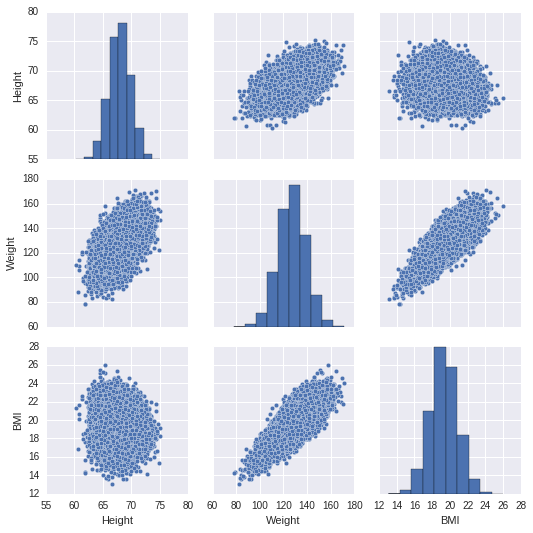

In [6]:
sns.pairplot(data, vars = ['Height', 'Weight', 'BMI'])

Добавим ещё один новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. 
А также посторим график boxplot, демонстрирующий зависимость роста от весовой категории, воспользовавшись одноимённым методом библиотеки Seaborn:

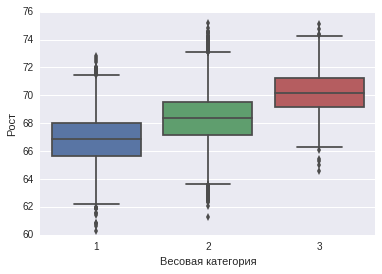

In [7]:
# определение весовой категории
def weight_category(weight):
    if weight < 120:
        return 1
    if weight >= 150:
        return 3
    else:
        return 2

# добавление нового признака:
data['weight_cat'] = data['Weight'].apply(weight_category)
# построение boxplot:
sns.boxplot(x = 'weight_cat', y = 'Height', data = data).set(xlabel='Весовая категория', ylabel='Рост')

Построим scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*.

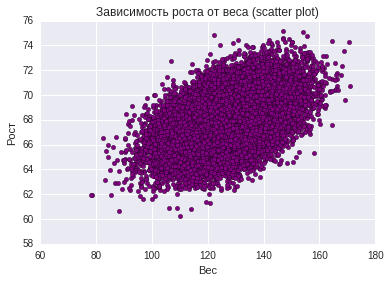

In [8]:
# функция построения scatter plot
def scplot():
    data.plot(x = 'Weight', y = 'Height', kind='scatter', 
    title = 'Зависимость роста от веса (scatter plot)', 
    color = 'purple').set( xlabel='Вес', ylabel='Рост')
scplot()

<h1>Минимизация квадратичной ошибки</h1>

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 
Опишем функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [9]:
# функция квадратичной ошибки:
def error(w0, w1):
    return sum((data.Height.values - (w0 + w1*data.Weight.values))**2)
error = np.vectorize(error)

Для начала отобразим  две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$ и убедимся, что они плохо передают зависимость роста от веса:

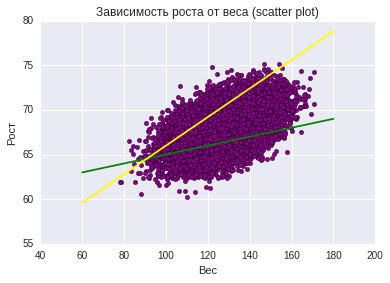

In [10]:
# scatter plot + прямые, соответствующие значениям параметров (w0,w1)=(60,0.05) и (w0,w1)=(50,0.16)
scplot()
x = np.linspace(60,180,100)
plt.plot(x, 0.05*x + 60, color = 'green')
plt.plot(x, 0.16*x + 50, color = 'yellow')
plt.show()

Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.
Построим график зависимости функции ошибки от параметра $w_1$ при $w_0$ = 50 :

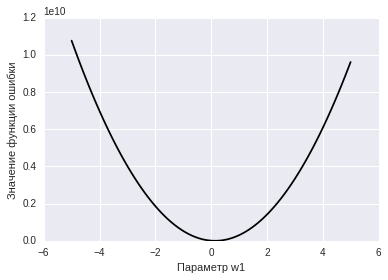

In [11]:
# график зависимости функции ошибки от параметра w1 при w0 = 50
x = np.linspace(-5,5,100)
plt.plot(x, error(50, x), color = 'black')
plt.xlabel('Параметр w1')
plt.ylabel('Значение функции ошибки')

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.
С помощью метода *minimize_scalar* из *scipy.optimize* найдём минимум функции ошибки для значений параметра  $w_1$ в диапазоне [-5,5]. После отобразим на графике scatter plot прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное оптимальное значение параметра $w_1$.

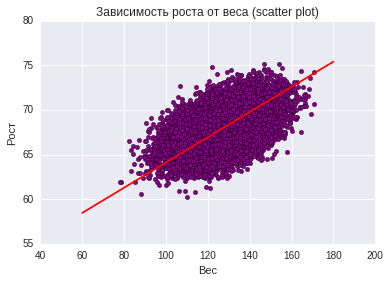

In [12]:
# оптимизация:
w1_opt = (scopt.minimize_scalar(lambda x:error(w0 = 50, w1 = x), bounds = (-5, 5)).x)
# построение графика:
scplot()
x = np.linspace(60,180,100)
plt.plot(x, w1_opt*x + 50, color = 'red')

Теперь построим 3D-график зависимости функции ошибки от параметров $w_0$ и $w_1$:

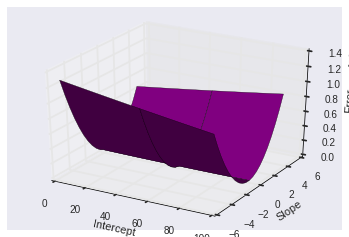

In [13]:
# создаем объекты типа matplotlib.figure.Figure (рисунок) и matplotlib.axes._subplots.Axes3DSubplot (ось)
fig = plt.figure()
ax = fig.gca(projection='3d') 

# создаем массивы NumPy с координатами точек по осям X и У:
X = np.arange(0, 100, 5)
Y = np.arange(-5, 5, 0.5)
# используем метод meshgrid, при котором по векторам координат создается матрица координат:
X, Y = np.meshgrid(X, Y)
# задаем нужную функцию Z(x, y):
Z = error(X,Y)
# строим график:
surf = ax.plot_surface(X, Y, Z, color = 'purple')
ax.set(xlabel = 'Intercept', ylabel = 'Slope', zlabel = 'Error')
plt.show()

С помощью метода *minimize* из scipy.optimize найдём минимум функции ошибок для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). В качестве используемого метода оптимизации выберем L-BFGS-B.
В завершение, проведём на графике scatter plot прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$.

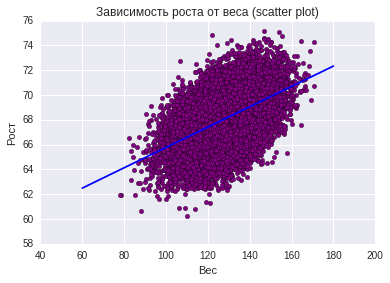

In [14]:
# оптимизация:
w0_min, w1_min = scopt.minimize(lambda w: error(w[0],w[1]), x0 = (0,0),
                                bounds = ((-100, 100), (-5, 5)), method = 'L-BFGS-B').x
# построение графика:
scplot()
x = np.linspace(60,180,100)
plt.plot(x, w1_min*x + w0_min, color = 'b')